In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
% matplotlib inline

In [2]:
df = pd.read_csv('data/food52_scraped_data.csv')

In [3]:
df.head()

,_id,rating,recipe,title,weblink
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...


In [4]:
df.dropna(inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 0 to 9714
Data columns (total 5 columns):
_id        9233 non-null object
rating     9233 non-null int64
recipe     9233 non-null object
title      9233 non-null object
weblink    9233 non-null object
dtypes: int64(1), object(4)
memory usage: 432.8+ KB


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from time import time
import seaborn as sns

In [7]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
def clustering_algorithm(tfidf, labels):

    svd = TruncatedSVD(algorithm='randomized', random_state=42)
    X_new = svd.fit_transform(tfidf)
    tsne_mod = TSNE(n_components=3, verbose=1, random_state=0, perplexity=40)
    coords = tsne_mod.fit_transform(X_new)
    x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
    return x, y, z


In [11]:
"""Additional words to add to stop words"""
rec_stop ="cup cups tablespoon tablespoons teaspoon teaspoons pounds ounces grams gram kilograms kilogram liter liters sliced diced minced finely coarsely roughly cut peeled chopped".split()

In [13]:
from sklearn.feature_extraction import text
def topic_extraction(df, col_name):
    """
    Two algorithms for topic extraction -
    NMF and LatentDirichletAllocation(LDA).
    my_stop_words combines built-in english stop words with recipe measurement/cutting terms 
    """
    my_stop_words = text.ENGLISH_STOP_WORDS.union(rec_stop)
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=200,
                                       analyzer='word',
                                       stop_words=my_stop_words)
    tfidf = tfidf_vectorizer.fit_transform(df[col_name])
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=200,
                                    stop_words=my_stop_words)
    tf = tf_vectorizer.fit_transform(df[col_name])

    nmf = NMF(n_components=6, random_state=1,
            alpha=.1, l1_ratio=.5)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    nmf_w = nmf.fit_transform(tfidf)
    nmf_h = nmf.components_
    labels = nmf_w.argmax(axis=1)
    df['labels2'] = labels # this was the right code to get labels/clusters
#     labels = df['labels'].values

    # tsne_algorithm(tfidf) # feed the tsne algorithm
    # sns.distplot(df['labels'], kde=True)
    # plt.show()
    print("\nTopics in NMF model:")
    print_top_words(nmf, tfidf_feature_names)
#     clustering_algorithm(nmf_w_short, labels)
    """uncomment to LDA topics"""
    lda = LatentDirichletAllocation(n_components=4, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0,
                                n_jobs=-1)
    mod = lda.fit(tf)
    comp = mod.fit_transform(tf)
    lda_labels = comp.argmax(axis=1)
    df['lda_topics2'] = lda_labels
    print("\nTopics in LDA model:")
    tf_feature_names = tf_vectorizer.get_feature_names()
    print_top_words(lda, tf_feature_names)
    
    return df, labels, lda_labels, tfidf, tf
    

def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print('End')

In [14]:
df4, labels4, lda_labels4, tfidf, tf = topic_extraction(df, 'recipe')


Topics in NMF model:
Topic #0:
oil olive chicken pepper garlic red fresh large salt onion cloves small taste medium leaves white wine tomatoes thyme dried
Topic #1:
flour sugar butter purpose baking vanilla unsalted extract water powder salt egg milk eggs plus soda room temperature cold granulated
Topic #2:
sauce soy sesame rice ginger oil vinegar sugar garlic brown chicken pork chili seeds green water lime vegetable cloves honey
Topic #3:
lemon juice fresh zest lime ounce orange freshly mint honey sugar olive water taste leaves garnish salt oil syrup pinch
Topic #4:
ground black freshly pepper powder pound beef cumin salt kosher cinnamon pork dried paprika coriander cayenne garlic chili cloves onion
Topic #5:
cheese grated cream parmesan slices shredded bread heavy butter milk pound eggs fresh bacon egg pepper sour cooked thinly salt
End

Topics in LDA model:
Topic #0:
sauce oil pepper garlic chicken ground onion salt powder red cloves green ginger rice fresh cumin cilantro soy chili

In [15]:
x5, y5, z5 = clustering_algorithm(tf, labels4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9233 samples in 0.014s...
[t-SNE] Computed neighbors for 9233 samples in 0.346s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9233
[t-SNE] Computed conditional probabilities for sample 2000 / 9233
[t-SNE] Computed conditional probabilities for sample 3000 / 9233
[t-SNE] Computed conditional probabilities for sample 4000 / 9233
[t-SNE] Computed conditional probabilities for sample 5000 / 9233
[t-SNE] Computed conditional probabilities for sample 6000 / 9233
[t-SNE] Computed conditional probabilities for sample 7000 / 9233
[t-SNE] Computed conditional probabilities for sample 8000 / 9233
[t-SNE] Computed conditional probabilities for sample 9000 / 9233
[t-SNE] Computed conditional probabilities for sample 9233 / 9233
[t-SNE] Mean sigma: 0.064761
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.958397
[t-SNE] Error after 1000 iterations: 0.582283


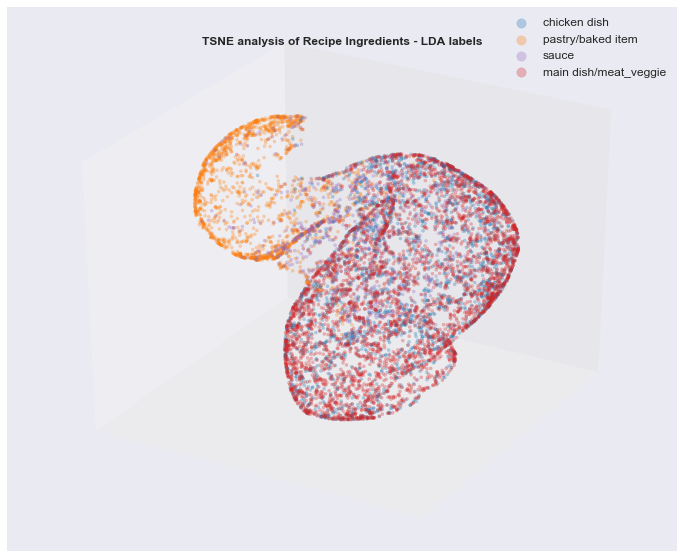

In [335]:
import matplotlib as mpl
""" LDA labels used to identify points in scatter plot of t-SNE analysis of recipe text"""
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:purple', 3:'tab:red'}
labels = {0:'chicken dish', 1:'pastry/baked item', 2:'sauce', 3:'main dish/meat_veggie'}
for k, b in colors.items():
    x, y, z = x5[np.where(lda_labels4 == k)], y5[np.where(lda_labels4 == k)], z5[np.where(lda_labels4 == k)]    
    ax.scatter(x, y, z, zdir='z', c=colors[k], label=labels[k], s=10, alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
ax.legend(fontsize=12, markerscale=3)
ax.set_title('TSNE analysis of Recipe Ingredients - LDA labels', fontsize=12, fontweight='bold')
ax.grid(False)

plt.savefig('data/recipe_ldalabels_tsne.png')

In [327]:
""" Creating animated gif by making a stack of plots at different angles """
for angle in range(70,210,2):

    # Make the plot
    fig = plt.figure(figsize=(15, 12))
    ax = fig.gca(projection='3d')
    colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:purple', 3:'tab:red'}
    labels = {0:'chicken dish', 1:'pastry/baked item', 2:'sauce', 3:'main dish/meat_veggie'}
    for k, b in colors.items():
        x, y, z = x5[np.where(labels4 == k)], y5[np.where(labels4 == k)], z5[np.where(labels4 == k)]    
        ax.scatter(x, y, z, zdir='z', c=colors[k], label=labels[k], s=10, alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    ax.legend(fontsize=14, markerscale=3)
    ax.set_title('TSNE analysis of Recipe Ingredients - LDA labels', fontsize=16, fontweight='bold')
    ax.grid(False)

    # Set the angle of the camera
    ax.view_init(30,angle)

    # Save it
    filename='data/lda_stack/3d_TSNE_LDA_step'+str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()
    plt.clf()
    plt.close()

In [19]:
x6, y6, z6 = clustering_algorithm(tfidf, labels4)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9233 samples in 0.018s...
[t-SNE] Computed neighbors for 9233 samples in 0.338s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9233
[t-SNE] Computed conditional probabilities for sample 2000 / 9233
[t-SNE] Computed conditional probabilities for sample 3000 / 9233
[t-SNE] Computed conditional probabilities for sample 4000 / 9233
[t-SNE] Computed conditional probabilities for sample 5000 / 9233
[t-SNE] Computed conditional probabilities for sample 6000 / 9233
[t-SNE] Computed conditional probabilities for sample 7000 / 9233
[t-SNE] Computed conditional probabilities for sample 8000 / 9233
[t-SNE] Computed conditional probabilities for sample 9000 / 9233
[t-SNE] Computed conditional probabilities for sample 9233 / 9233
[t-SNE] Mean sigma: 0.007847
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.588409
[t-SNE] Error after 1000 iterations: 0.595807


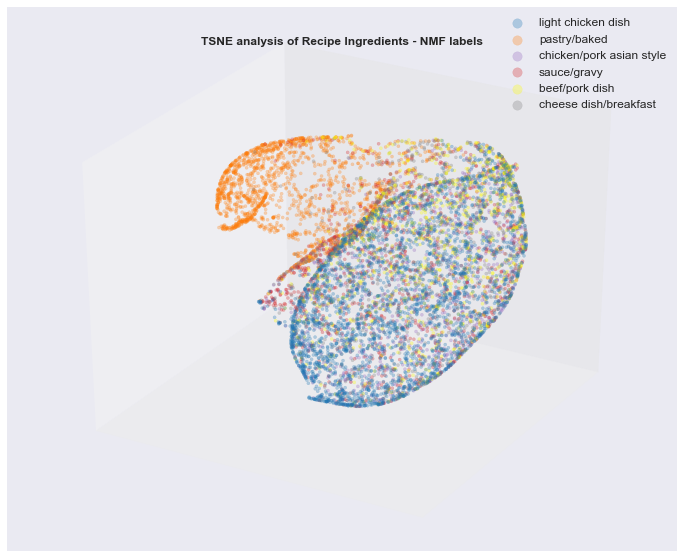

In [336]:
""" NMF labels used to identify points in scatter plot of t-SNE analysis of recipe text"""
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:purple', 3:'tab:red', 4:'yellow', 5:'gray'}
labels = {0:'light chicken dish', 1:'pastry/baked', 2:'chicken/pork asian style', 3:'sauce/gravy', 4:'beef/pork dish', 5:'cheese dish/breakfast'}
for k, b in colors.items():
    x, y, z = x6[np.where(labels4 == k)], y6[np.where(labels4 == k)], z6[np.where(labels4 == k)]    
    ax.scatter(x, y, z, zdir='z', c=colors[k], label=labels[k], s=10, alpha=0.3)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
ax.legend(fontsize=12, markerscale=3)
ax.set_title('TSNE analysis of Recipe Ingredients - NMF labels', fontsize=12, fontweight='bold')
ax.grid(False)
plt.savefig('data/recipe_nmfclustering_tsne.png')

In [329]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


for angle in range(70,210,2):

    # Make the plot
    fig = plt.figure(figsize=(15, 15))
    ax = fig.gca(projection='3d')
    colors = {0:'tab:blue', 1:'tab:orange', 2:'tab:purple', 3:'tab:red', 4:'yellow', 5:'gray'}
    labels = {0:'light chicken dish', 1:'pastry/baked', 2:'chicken/pork asian style', 3:'sauce/gravy', 4:'beef/pork dish', 5:'cheese dish/breakfast'}
    for k, b in colors.items():
        x, y, z = x6[np.where(labels4 == k)], y6[np.where(labels4 == k)], z6[np.where(labels4 == k)]    
        ax.scatter(x, y, z, zdir='z', c=colors[k], label=labels[k], s=10, alpha=0.3)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])

    ax.legend(fontsize=16, markerscale=3)
    ax.set_title('TSNE analysis of Recipe Ingredients - NMF labels', fontsize=16, fontweight='bold')
    ax.grid(False)
    # Set the angle of the camera
    ax.view_init(30,angle)
    # Save
    filename='data/3d_stack/3d_TSNE_step'+str(angle)+'.png'
    plt.savefig(filename, dpi=96)
    plt.gca()
    plt.clf()
    plt.close()

In [25]:
df.head()

,_id,rating,recipe,title,weblink,labels2,lda_topics2
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...,5,0
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...,4,2
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...,1,1
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...,0,3
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...,3,2


In [26]:
df2 = pd.read_csv('data/food52_addenda_transformed.csv')

In [27]:
df2.reset_index(inplace=True)

In [28]:
del df2['index']
del df2['Unnamed: 0']

In [30]:
df2.head()

,date_submitted,rating,servings,title,user_comments,number_comments,date_formatted
0,"April 14, 2011",55,4.0,Beef Stroganoff with Mushrooms and Onions,"[""\n\nabout 3 years ago\nCampCook\n\nThere is ...",5,2011-04-14
1,"October 3, 2016",1,NaN,Asian Sliders with Gochujang Mayo,[],0,2011-04-14
2,"August 13, 2014",3,NaN,Ground Turkey Stroganoff,['\n\n10 months ago\nHodie-Hi\n\nIngredients l...,2,2011-04-14
3,"October 4, 2017",64,68.0,Austin Diner-Style Queso,['\n\n23 days ago\nalex\n\nDo as the locals do...,8,2011-04-14
4,"September 18, 2017",38,1.0,Mamba (Spicy Haitian Peanut Butter),"['\n\n26 days ago\nRegine\n\n“Cooking in HMB,”...",6,2011-04-14


In [33]:
# **Resume from here - notebook was run up to this cell

In [22]:
# df2['ratio'] = df2['number_comments'] / df2['rating']

In [23]:
# df2.replace([np.inf, -np.inf], np.nan, inplace=True)

In [24]:
# df2.dropna(inplace=True)

In [25]:
# df2['ratio'].mean() 

In [31]:
new_df = df.merge(df2, how='left', on='title')

In [32]:
new_df.drop_duplicates(subset='title', inplace=True)

## Analysis of time effect

In [31]:
time_analysis = new_df[['title', 'rating_x', 'rating_y', 'date_submitted']]

In [32]:
time_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9235 entries, 0 to 9234
Data columns (total 4 columns):
title             9235 non-null object
rating_x          9235 non-null int64
rating_y          9235 non-null int64
date_submitted    9235 non-null object
dtypes: int64(2), object(2)
memory usage: 360.7+ KB


In [36]:
# pd.to_datetime(time_analysis['date_submitted'], )
time_analysis.iloc[0, 3]

'October 4, 2017'

In [51]:

def date_change(col):
    return pd.to_datetime(col)

In [43]:
time_analysis['true_date'] = time_analysis['date_submitted'].apply(date_change)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [56]:
date_x = pd.to_datetime('October 30, 2017')

In [57]:
time_analysis['recipe_age'] = date_x - time_analysis['true_date']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [59]:
time_analysis['delta_rating_45d'] = time_analysis['rating_y'] - time_analysis['rating_x']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [66]:
time_analysis.rename(columns={'true_date': 'recipe_date'}, inplace=True)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/pandas/core/frame.py:2844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [62]:
del time_analysis['date_submitted']

In [147]:
def time_d(col):
    return np.float32(col.days)
time_analysis['recipe_age'] = time_analysis['recipe_age'].apply(time_d)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [72]:
time_analysis['percent_change'] = (time_analysis['delta_rating_45d'] / (time_analysis['rating_x'] - 1)) * 100

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
time_analysis.hist('recipe_age', bins=20)
# plt.xlim([-5, 20])

## Creating stacked user/recipe/comments

In [34]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9233 entries, 0 to 9233
Data columns (total 13 columns):
_id                9233 non-null object
rating_x           9233 non-null int64
recipe             9233 non-null object
title              9233 non-null object
weblink            9233 non-null object
labels2            9233 non-null int64
lda_topics2        9233 non-null int64
date_submitted     9233 non-null object
rating_y           9233 non-null int64
servings           7437 non-null float64
user_comments      9233 non-null object
number_comments    9233 non-null int64
date_formatted     9233 non-null object
dtypes: float64(1), int64(5), object(7)
memory usage: 1009.9+ KB


In [35]:
new_df['date_formatted'] = new_df['date_submitted'].apply(lambda x: pd.to_datetime(x))

In [54]:
new_df.head()

,_id,rating_x,recipe,title,weblink,labels2,lda_topics2,date_submitted,rating_y,servings,user_comments,number_comments,date_formatted,clean_comments
0,59d7cf29a980892888190548,14,2 tablespoons unsalted butter\n1/4 cup diced y...,Austin Diner-Style Queso,https://food52.com/recipes/73529-austin-diner-...,5,0,"October 4, 2017",64,68.0,['\n\n23 days ago\nalex\n\nDo as the locals do...,8,2017-10-04,"[[alex, , Do as the locals do: On the stovetop..."
1,59d7cf30a98089288819054a,29,1 pound shelled raw peanuts\n1 tablespoon plus...,Mamba (Spicy Haitian Peanut Butter),https://food52.com/recipes/73211-mamba-spicy-h...,4,2,"September 18, 2017",38,1.0,"['\n\n26 days ago\nRegine\n\n“Cooking in HMB,”...",6,2017-09-18,"[[Regine, , “Cooking in HMB,” recipe asks for ..."
2,59d7cf39a98089288819054c,2,2 cups (8 1/2 ounces) all-purpose flour\n1/2 c...,Sheet Pan Muffins,https://food52.com/recipes/73548-sheet-pan-muf...,1,1,"October 5, 2017",76,NaN,"[""\n\n11 days ago\nGumba\n\nReminds me of HoJo...",14,2017-10-05,"[[Gumba, , Reminds me of HoJo's blueberry toas..."
3,59d7cf3fa98089288819054e,92,"1 1/2 cups (300g) Puy lentils, washed\n4 clove...",Anna Jones' Favorite Lentils with Roasted Toma...,https://food52.com/recipes/73511-anna-jones-fa...,0,3,"October 3, 2017",130,4.0,['\n\n18 days ago\nJenn Travis\n\nThese are so...,10,2017-10-03,"[[Jenn Travis, , These are so so yummy. They w..."
4,59d7cf48a980892888190550,3,2 ounces Seedlip Garden 108\n0.75 ounces Lemon...,Seedlip's A Good Dill,https://food52.com/recipes/73252-seedlip-s-a-g...,3,2,"September 21, 2017",5,1.0,[],0,2017-09-21,[]


In [39]:
test = "".join(new_df.iloc[2, 10])

In [40]:
import ast
test_lst = ast.literal_eval(test)

In [41]:
new_df['clean_comments'] = new_df['user_comments'].apply(lambda x: ast.literal_eval(x))

In [42]:
def clean_com(col):
    return [item.split('\n')[3:]for item in col]
        
        

In [43]:
new_df['clean_comments'] = new_df['clean_comments'].apply(clean_com)

In [51]:
new_df.to_csv('data/combined_scrapes.csv')

In [52]:
senti_df = new_df[['title', 'clean_comments', 'number_comments', 'rating_x']]

In [47]:
# def title_mul(col):
#     return list(col)

In [53]:
senti_df['title_mul'] = senti_df['title'].apply(lambda x: [x])

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [64]:
def fill_empty(col):
    if col == 0:
        return 1
    else:
        return col

senti_df['number_comments'] = senti_df['number_comments'].apply(fill_empty)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [65]:
senti_df['title_mul_f'] = senti_df['title_mul'] * senti_df['number_comments']

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [63]:
def zero_comment(col):
    if col == []:
        return [[0]]
    else:
        return col
senti_df['clean_comments'] = senti_df['clean_comments'].apply(zero_comment)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
comments = senti_df['clean_comments']

        

In [80]:
len(comments)

9233

In [77]:
titles = senti_df['title_mul_f']

In [78]:
combo = []
for n in range(len(comments)):
    comb = list(zip(comments[n], titles[n]))
    combo.extend(comb)

KeyError: 9232

In [81]:
len(combo)

55943

In [82]:
df_working = pd.DataFrame.from_records(combo)

In [83]:
df_working.head()

,0,1
0,"[alex, , Do as the locals do: On the stovetop ...",Austin Diner-Style Queso
1,"[petalpusher, , This recipe is good for those ...",Austin Diner-Style Queso
2,"[EmFraiche, , How much water do you add? I don...",Austin Diner-Style Queso
3,"[Jennifer M, , I put in equal parts milk and w...",Austin Diner-Style Queso
4,"[Ceil_the_great, , Sounds tasty! Can you recom...",Austin Diner-Style Queso


In [84]:
df_working.columns = 'user_comment recipe_title'.split()

In [85]:
df_working.head()

,user_comment,recipe_title
0,"[alex, , Do as the locals do: On the stovetop ...",Austin Diner-Style Queso
1,"[petalpusher, , This recipe is good for those ...",Austin Diner-Style Queso
2,"[EmFraiche, , How much water do you add? I don...",Austin Diner-Style Queso
3,"[Jennifer M, , I put in equal parts milk and w...",Austin Diner-Style Queso
4,"[Ceil_the_great, , Sounds tasty! Can you recom...",Austin Diner-Style Queso


In [86]:
def user_id(col):
    if col != []:
        return col[0]
    else:
        return None
df_working['user'] = df_working['user_comment'].apply(user_id)

In [90]:
df_working.iloc[0, 0][2]

'Do as the locals do: On the stovetop or in the microwave melt 1 block of velveeta cheese and one can of rotel tomatoes.  If you are feeling fancy you can mix in pickled jalapenos, guacamole, ground beef sauteed with onions, or black beans.  Enjoy with college football.'

In [91]:
df_working['comment'] = df_working['user_comment'].apply(lambda x: x[2:])

In [101]:
df_working['comment'] = df_working['comment'].apply(lambda x: x[0] if x != [] else "")

In [93]:
del df_working['user_comment']

In [94]:
df_working.to_csv('data/recipe_user_comment.csv')

In [95]:
import nltk

In [96]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [97]:
slc = SentimentIntensityAnalyzer()

In [98]:
slc.polarity_scores('I am a blah')

{'compound': -0.1027, 'neg': 0.583, 'neu': 0.417, 'pos': 0.0}

In [99]:
def sentence_pos(col):
    return slc.polarity_scores(col)

In [102]:
df_working['pol_scores'] = df_working['comment'].apply(sentence_pos)

In [109]:
df_working['pol_scores'][55871]

{'compound': 0.0, 'neg': 0.0, 'neu': 0.0, 'pos': 0.0}

In [308]:
df_working['compound'] = df_working['pol_scores'].apply(lambda x: x['compound'])

In [269]:
def implicit(col):
    comp, neut = col['compound'], col['neu']
    if comp == 0 and comp == 0:
        return 0
    if comp < 0:
        return 1
    if comp > 0 and comp <= 0.6:
        return 2
    if comp > 0.6:
        return 3
df_working['implicit'] = df_working['pol_scores'].apply(implicit)

In [270]:
df_working['implicit'].value_counts()

3    26108
0    16047
2    10123
1     3665
Name: implicit, dtype: int64

In [265]:
senti_df.head()

,title,clean_comments,number_comments,rating_x,title_mul,title_mul_f
0,Austin Diner-Style Queso,"[[alex, , Do as the locals do: On the stovetop...",8,14,[Austin Diner-Style Queso],"[Austin Diner-Style Queso, Austin Diner-Style ..."
1,Mamba (Spicy Haitian Peanut Butter),"[[Regine, , “Cooking in HMB,” recipe asks for ...",6,29,[Mamba (Spicy Haitian Peanut Butter)],"[Mamba (Spicy Haitian Peanut Butter), Mamba (S..."
2,Sheet Pan Muffins,"[[Gumba, , Reminds me of HoJo's blueberry toas...",14,2,[Sheet Pan Muffins],"[Sheet Pan Muffins, Sheet Pan Muffins, Sheet P..."
3,Anna Jones' Favorite Lentils with Roasted Toma...,"[[Jenn Travis, , These are so so yummy. They w...",10,92,[Anna Jones' Favorite Lentils with Roasted Tom...,[Anna Jones' Favorite Lentils with Roasted Tom...
4,Seedlip's A Good Dill,[[0]],1,3,[Seedlip's A Good Dill],[Seedlip's A Good Dill]


In [131]:
title_ratings = {}
for n in range(len(senti_df['rating_x'])):
    k = senti_df.iloc[n, 0]
    v = senti_df.iloc[n, 3]
    v2 = senti_df.iloc[n, 2]
    title_ratings[k] = [v, v2]

In [196]:
lst = list(title_ratings.values())
x, y = [np.log(item[0]+0.1) for item in lst], [item[1] for item in lst]

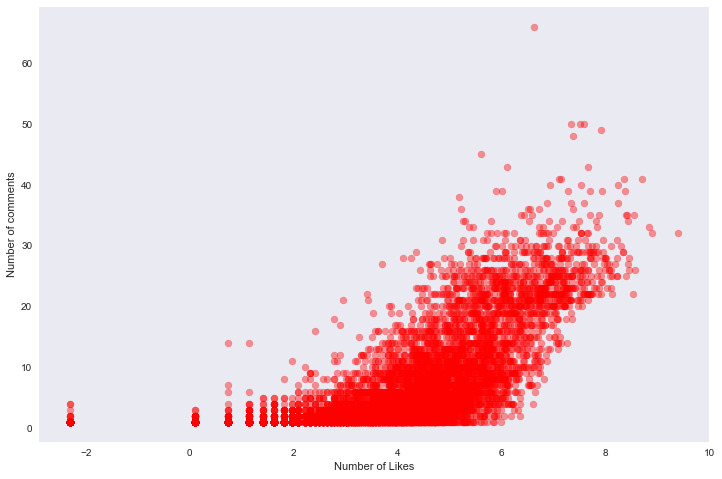

In [204]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y, c='r', alpha=0.4)
ax.set_xlabel('Number of Likes')
ax.set_ylabel('Number of comments')
ax.grid(False)

In [159]:
import scipy.stats as scs

In [198]:
# x2 = np.log(np.array(x))
slope, intercept, r_value, p_value, std_err = scs.linregress(x,y)


In [205]:
from sklearn.linear_model import LinearRegression

In [206]:
lr = LinearRegression()

In [216]:
x_arr = np.array(x).reshape(-1, 1)
y_arr = np.array(y).reshape(-1, 1)
lr.fit(x_arr, y_arr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [249]:
inter = lr.intercept_

In [248]:
slope = lr.coef_

In [266]:
(df_working['rating'].mean()) * (lr.coef_)

array([[ 4.12976423]])

In [250]:
for k, v in title_ratings.items():
    rating = v[0]
    pred_likes = np.log(rating + 0.1) * slope + inter
    bias = v[1] - pred_likes
    title_ratings[k].append(bias)

In [253]:
true_pred = [(v[0], v[2]) for k, v in title_ratings.items()]

In [257]:
pred_bias = [b for (a, b) in true_pred]

In [262]:
pred_bias

[array([[ 3.15962286]]),
 array([[-0.38276495]]),
 array([[ 13.21319875]]),
 array([[ 1.164666]]),
 array([[-0.61586014]]),
 array([[-3.84037714]]),
 array([[-1.2110162]]),
 array([[ 3.03031773]]),
 array([[-1.2110162]]),
 array([[-2.66040842]]),
 array([[ 1.5896827]]),
 array([[ 1.01376353]]),
 array([[-2.66040842]]),
 array([[-0.45253714]]),
 array([[-2.98144641]]),
 array([[ 5.59218538]]),
 array([[ 1.5896827]]),
 array([[ 4.64405825]]),
 array([[-1.65693284]]),
 array([[-1.13015452]]),
 array([[-2.66040842]]),
 array([[-3.51474924]]),
 array([[-2.66040842]]),
 array([[-2.66040842]]),
 array([[-5.38276495]]),
 array([[ 12.16792214]]),
 array([[-2.33112568]]),
 array([[ 1.21319875]]),
 array([[-2.59162976]]),
 array([[-2.37990938]]),
 array([[-3.51474924]]),
 array([[ 3.28348665]]),
 array([[-0.95640237]]),
 array([[-2.12273922]]),
 array([[-4.89123319]]),
 array([[ 5.54531221]]),
 array([[-2.37199596]]),
 array([[-3.51474924]]),
 array([[-3.33112568]]),
 array([[-2.09677603]]),
 arr

In [271]:
# df_working.to_csv('data/implicit_ratings3.csv')

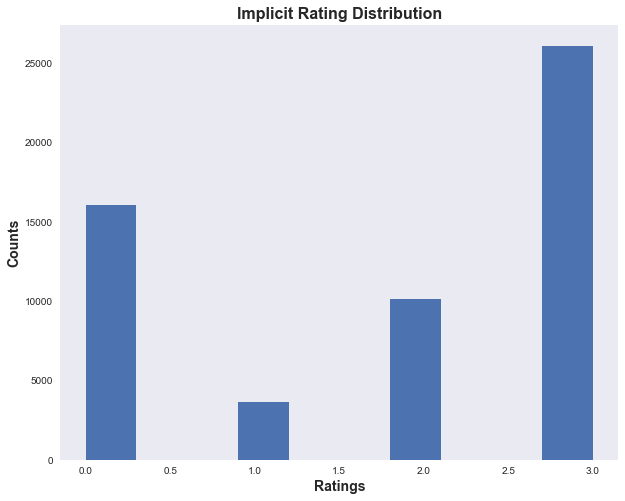

In [275]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(df_working['implicit'])
ax.grid(False)
ax.set_title('Implicit Rating Distribution', fontsize=16, fontweight='bold')
ax.set_ylabel('Counts', fontsize=14, fontweight='bold')
ax.set_xlabel('Ratings', fontsize=14, fontweight='bold')
plt.savefig('data/implicit_dist.png')

In [274]:
df_working['implicit'].value_counts()

3    26108
0    16047
2    10123
1     3665
Name: implicit, dtype: int64

In [221]:
df_working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55943 entries, 0 to 55942
Data columns (total 5 columns):
recipe_title    55943 non-null object
user            55943 non-null object
comment         55943 non-null object
pol_scores      55943 non-null object
implicit        55943 non-null int64
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [222]:
df_working['user'].value_counts()

0                      3040
AntoniaJames            783
sdebrango               586
aargersi                389
lapadia                 379
boulangere              376
hardlikearmour          354
mrslarkin               342
TheWimpyVegetarian      314
drbabs                  306
gingerroot              292
Sagegreen               286
dymnyno                 272
Midge                   244
fiveandspice            242
EmilyC                  237
LE BEC FIN              227
Kristen Miglore         221
healthierkitchen        219
Bevi                    195
sexyLAMBCHOPx           190
Lizthechef              189
wssmom                  151
ChefJune                143
QueenSashy              135
lastnightsdinner        134
Regine                  127
luvcookbooks            122
inpatskitchen           118
cheese1227              117
                       ... 
lyve life                 1
Scott Stephan             1
Michelle Sellars          1
c                         1
Meagan Kelly        

In [276]:
df_working.head()

,recipe_title,user,comment,pol_scores,rating,implicit
0,Austin Diner-Style Queso,alex,Do as the locals do: On the stovetop or in the...,"{'neg': 0.056, 'neu': 0.853, 'pos': 0.091, 'co...",2,2
1,Austin Diner-Style Queso,petalpusher,This recipe is good for those of us who are al...,"{'neg': 0.137, 'neu': 0.683, 'pos': 0.18, 'com...",2,2
2,Austin Diner-Style Queso,EmFraiche,How much water do you add? I don’t see an amount.,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0,0
3,Austin Diner-Style Queso,Jennifer M,I put in equal parts milk and water and it see...,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",2,2
4,Austin Diner-Style Queso,Ceil_the_great,Sounds tasty! Can you recommend a substitute f...,"{'neg': 0.0, 'neu': 0.864, 'pos': 0.136, 'comp...",3,2


In [337]:
comments = df_working['comment'][2]

In [338]:
comments


'How much water do you add? I don’t see an amount.'

In [277]:
df_working.rename(columns={'implicit': 'rating'}, inplace=True)

In [278]:
df_rec = df_working[['user', 'recipe_title', 'rating']]

In [279]:
df_rec['user'].drop(0, inplace=True)

In [280]:
user_dict = {user: num for num, user in enumerate(list(set(df_rec['user'])))}

In [281]:
recipe_dict = {recipe: num for num, recipe in enumerate(list(set(df_rec['recipe_title'])))}

In [282]:
def recipe_id(col):
    return recipe_dict[col]
def user_id(col):
    return user_dict[col]

In [283]:
df_rec['recipe_id'] = df_rec['recipe_title'].apply(recipe_id)
df_rec['user_id'] = df_rec['user'].apply(user_id)

/Applications/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [284]:
df_rec.head()

,user,recipe_title,rating,rating,recipe_id,user_id
0,alex,Austin Diner-Style Queso,2,2,1283,3604
1,petalpusher,Austin Diner-Style Queso,2,2,1283,1772
2,EmFraiche,Austin Diner-Style Queso,0,0,1283,15674
3,Jennifer M,Austin Diner-Style Queso,2,2,1283,5953
4,Ceil_the_great,Austin Diner-Style Queso,3,2,1283,5290


In [285]:
df_final = df_rec[['user_id', 'recipe_id', 'rating']]

In [286]:
df_final.to_csv('data/f52_user_item_rating3.csv')